<a href="https://colab.research.google.com/github/VahidNaghashi/LSTM-from-scratch/blob/master/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.python.framework import ops
from skimage import io, transform
from tqdm import tqdm


In [8]:
df = pd.read_csv("gdrive/My Drive/ML-project/ISIC2018_Task3_Training_GroundTruth.csv")
labels = np.array(df.iloc[:, 1:]).astype(int)

image_names = []
for i in range(labels.shape[1]):
    print('Class {} instances: {}'.format(i+1, np.count_nonzero(np.where(labels[:, i] == 1))))
    indexes = np.argwhere(labels[:, i] == 1)
    indexes = indexes.squeeze()
    image_names.append(df['image'][indexes].tolist())
    
print(labels.shape)

Class 1 instances: 1113
Class 2 instances: 6704
Class 3 instances: 514
Class 4 instances: 327
Class 5 instances: 1099
Class 6 instances: 115
Class 7 instances: 142
(10015, 7)


In [9]:
#train_x = np.zeros((int(df['image'].shape[0]), 224, 224, 3))
train_x = []

for i in tqdm(range(int(df['image'].shape[0]))): 
  
  im_name = df['image'][i]
  image = io.imread("gdrive/My Drive/ISIC2018_Task3_Training_Input/" + im_name + ".jpg")
  image = transform.resize(image, (224, 224))
  image = np.array(image).astype('float32')
  image /= 255.
  
  train_x.append(image)

  0%|          | 0/10015 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
 57%|█████▋    | 5708/10015 [35:32<27:09,  2.64it/s]

KeyboardInterrupt: ignored

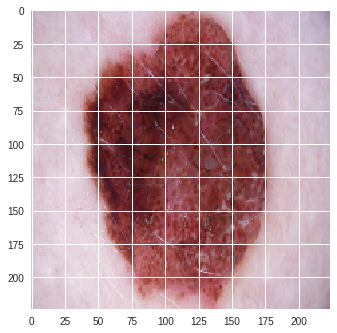

In [0]:
plt.imshow(train_x[-1])

In [0]:
#from tqdm import tqdm

#for i in tqdm(range(len(train_x))):
  
#  train_x[i] = train_x[i].astype('float32')
#  train_x[i] = train_x[i] / 255.

#train_x = train_x.astype('float32')
#x_test = x_test.astype('float32')
#train_x /= 255.
#x_test /= 255.
#X_train = train_x
Y_train = labels
#plt.imshow(X_train[0])
Y_train.shape[1]

100%|██████████| 10015/10015 [01:46<00:00, 93.74it/s]


7

In [0]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = np.random.permutation(m)
    #shuffled_X = [X[i] for i in permutation]
    #shuffled_Y = Y[permutation,:]
    idx = permutation

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        #mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        #mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        #mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batch = permutation[k*mini_batch_size:k*mini_batch_size + mini_batch_size]
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        #mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        #mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        #mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batch = permutation[num_complete_minibatches*mini_batch_size:m]
        mini_batches.append(mini_batch)
    
    return mini_batches


In [0]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    ### START CODE HERE ### (≈2 lines)
    X = tf.placeholder('float', (None, n_H0, n_W0, n_C0))
    Y = tf.placeholder('float', (None, n_y))
    ### END CODE HERE ###
    
    return X, Y

In [0]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [3, 3, 1, 16]
                        W2 : [3, 3, 16, 16]
                        W3 : [3, 3, 16, 32]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 2 lines of code)
    W1 = tf.get_variable("w1", [3, 3, 3, 64], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [3, 3, 64, 64], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W3 = tf.get_variable("W3", [3, 3, 64, 128], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W4 = tf.get_variable("W4", [3, 3, 128, 128], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W5 = tf.get_variable("W5", [3, 3, 128, 256], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W6 = tf.get_variable("W6", [3, 3, 256, 256], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W7 = tf.get_variable("w7", [3, 3, 256, 256], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W8 = tf.get_variable("W8", [3, 3, 256, 512], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W9 = tf.get_variable("W9", [3, 3, 512, 512], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W10 = tf.get_variable("W10", [3, 3, 512, 512], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W11 = tf.get_variable("W11", [3, 3, 512, 512], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W12 = tf.get_variable("W12", [3, 3, 512, 512], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W12 = tf.get_variable("W13", [3, 3, 512, 512], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "W2": W2,
                  "W3": W3,
                  "W4": W4,
                  "W5": W5,
                  "W6": W6,
                  "W7": W7,
                  "W8": W8,
                  "W9": W9,
                  "W10":W10,
                  "W11":W11,
                  "W12":W12,
                  "W13":W13}
    
    return parameters

In [0]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    W4 = parameters['W4']
    W5 = parameters['W5']
    W6 = parameters['W6']
    W7 = parameters['W7']
    W8 = parameters['W8']
    W9 = parameters['W9']
    W10 = parameters['W10']
    W11 = parameters['W11']
    W12 = parameters['W12']
    W13 = parameters['W13']
    
    ### VGG16 model ###
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding="SAME")
    A1 = tf.nn.relu(Z1)
    Z2 = tf.nn.conv2d(A1, W2, strides=[1,1,1,1], padding="SAME")
    A2 = tf.nn.relu(Z2)
    P1 = tf.nn.max_pool(A2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    # 2nd step
    Z3 = tf.nn.conv2d(P1, W3, strides=[1,1,1,1], padding="SAME")
    A3 = tf.nn.relu(Z3)
    Z4 = tf.nn.conv2d(A3, W4, strides=[1,1,1,1], padding="SAME")
    A4 = tf.nn.relu(Z4)
    P2 = tf.nn.max_pool(A4, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    # 3rd step
    Z5 = tf.nn.conv2d(P2, W5, strides=[1,1,1,1], padding="SAME")
    A5 = tf.nn.relu(Z5)
    Z6 = tf.nn.conv2d(A5, W6, strides=[1,1,1,1], padding="SAME")
    A6 = tf.nn.relu(Z6)
    Z7 = tf.nn.conv2d(A6, W7, strides=[1,1,1,1], padding="SAME")
    A7 = tf.nn.relu(Z7)
    P3 = tf.nn.max_pool(A7, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    # 4th step
    Z8 = tf.nn.conv2d(P3, W8, strides=[1,1,1,1], padding="SAME")
    A8 = tf.nn.relu(Z8)
    Z9 = tf.nn.conv2d(A8, W9, strides=[1,1,1,1], padding="SAME")
    A9 = tf.nn.relu(Z9)
    Z10 = tf.nn.conv2d(A9, W10, strides=[1,1,1,1], padding="SAME")
    A10 = tf.nn.relu(Z10)
    P4 = tf.nn.max_pool(A10, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    # 5th step
    Z11 = tf.nn.conv2d(P4, W11, strides=[1,1,1,1], padding="SAME")
    A11 = tf.nn.relu(Z11)
    Z12 = tf.nn.conv2d(A11, W12, strides=[1,1,1,1], padding="SAME")
    A12 = tf.nn.relu(Z12)
    Z13 = tf.nn.conv2d(A12, W13, strides=[1,1,1,1], padding="SAME")
    A13 = tf.nn.relu(Z13)
    P5 = tf.nn.max_pool(A13, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    # FLATTEN
    # FLATTEN
    P5 = tf.contrib.layers.flatten(P5)
    # Fully connected layer (in tf contrib folder for now)
    #fc1 = tf.layers.dense(P3, 1024)
    # Apply Dropout (if is_training is False, dropout is not applied)
    #fc1 = tf.layers.dropout(fc1, rate=0.3, training=True)

    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z14 = tf.contrib.layers.fully_connected(P5, 7, activation_fn=None)
    ### END CODE HERE ###

    return Z14

In [0]:
def compute_cost(Z14, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (7, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    ### START CODE HERE ### (1 line of code)
    #tf.stop_gradient(Y,name=None)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z14, labels=Y))
    ### END CODE HERE ###
    
    return cost

In [0]:
def model(X_train, Y_train, learning_rate = 0.009,
          num_epochs = 2, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 48, 48, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 48, 48, 3)
    Y_test -- test set, of shape (None, n_y = 7)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    #ops.reset_default_graph()  
    ops.reset_default_graph()                          # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (n_H0, n_W0, n_C0) = X_train[0].shape 
    m = len(X_train)
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z14 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z14, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    
    #config = tf.ConfigProto()
    #config.gpu_options.allow_growth = True
    config = tf.ConfigProto()
    config.gpu_options.allocator_type = 'BFC'
    
    with tf.Session(config=config) as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                #(minibatch_X, minibatch_Y) = minibatch
                idx = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: np.array([X_train[i] for i in idx]), Y: Y_train[idx,:]})
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 1 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z14, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        #print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        #test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        #print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, parameters

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 1.940906
Cost after epoch 5: 0.978085
Cost after epoch 10: 0.981800
Cost after epoch 15: 0.890214
Cost after epoch 20: 0.812426
Cost after epoch 25: 0.545303
Cost after epoch 30: 0.505633
Cost after epoch 35: 0.279539
Cost after epoch 40: 0.160008
Cost after epoch 45: 0.136998
Cost after epoch 50: 0.074781
Cost after epoch 55: 0.016189
Cost after epoch 60: 0.003428
Cost after epoch 65: 0.366062
Cost after epoch 70: 0.200167
Cost after epoch 75: 0.099014
Cost after epoch 80: 0.014427
Cost after epoch 85: 0.007812
Cost after epoch 90: 0.004710
Cost after epoch 95: 0.138381


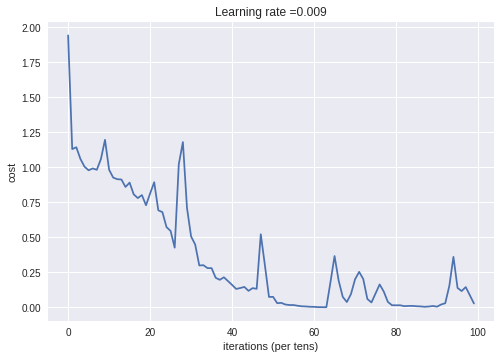

Tensor("Mean_1:0", shape=(), dtype=float32)


InvalidArgumentError: ignored

In [0]:
_, _, parameters = model(X_train, Y_train)

In [0]:

df = pd.read_csv("gdrive/My Drive/deneme.csv")
im_names = []

#im_names.append(df['image'][1:].tolist())

test_x = []

for i in tqdm(range(int(df['image'].shape[0]))): 
  
  im_name = df['image'][i]
  image = io.imread("gdrive/My Drive/ISIC2018_Task3_Test_Input/" + im_name + ".jpg")
  image = transform.resize(image, (224, 224))
  image = np.array(image).astype('float32')
  image /= 255.
  
  test_x.append(image)

In [0]:
def build_network(height, width, channel):
  
    X = tf.placeholder(tf.float32, shape=[None, height, width, channel], name='input')
    Y = tf.placeholder(tf.int64, shape=[None, 7], name='labels_placeholder')

    def weight_variable(shape, name="weights"):
        initial = tf.truncated_normal(shape, dtype=tf.float32, stddev=0.1)
        return tf.Variable(initial, name=name)

    def bias_variable(shape, name="biases"):
        initial = tf.constant(0.1, dtype=tf.float32, shape=shape)
        return tf.Variable(initial, name=name)

    def conv2d(input, w):
        return tf.nn.conv2d(input, w, [1, 1, 1, 1], padding='SAME')

    def pool_max(input):
        return tf.nn.max_pool(input,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool1')

    def fc(input, w, b):
        return tf.matmul(input, w) + b

    # conv1
    with tf.name_scope('conv1_1') as scope:
        kernel = weight_variable([3, 3, 3, 64])
        biases = bias_variable([64])
        output_conv1_1 = tf.nn.relu(conv2d(X, kernel) + biases, name=scope)

    with tf.name_scope('conv1_2') as scope:
        kernel = weight_variable([3, 3, 64, 64])
        biases = bias_variable([64])
        output_conv1_2 = tf.nn.relu(conv2d(output_conv1_1, kernel) + biases, name=scope)

    pool1 = pool_max(output_conv1_2)

    # conv2
    with tf.name_scope('conv2_1') as scope:
        kernel = weight_variable([3, 3, 64, 128])
        biases = bias_variable([128])
        output_conv2_1 = tf.nn.relu(conv2d(pool1, kernel) + biases, name=scope)

    with tf.name_scope('conv2_2') as scope:
        kernel = weight_variable([3, 3, 128, 128])
        biases = bias_variable([128])
        output_conv2_2 = tf.nn.relu(conv2d(output_conv2_1, kernel) + biases, name=scope)

    pool2 = pool_max(output_conv2_2)

    # conv3
    with tf.name_scope('conv3_1') as scope:
        kernel = weight_variable([3, 3, 128, 256])
        biases = bias_variable([256])
        output_conv3_1 = tf.nn.relu(conv2d(pool2, kernel) + biases, name=scope)

    with tf.name_scope('conv3_2') as scope:
        kernel = weight_variable([3, 3, 256, 256])
        biases = bias_variable([256])
        output_conv3_2 = tf.nn.relu(conv2d(output_conv3_1, kernel) + biases, name=scope)

    with tf.name_scope('conv3_3') as scope:
        kernel = weight_variable([3, 3, 256, 256])
        biases = bias_variable([256])
        output_conv3_3 = tf.nn.relu(conv2d(output_conv3_2, kernel) + biases, name=scope)

    pool3 = pool_max(output_conv3_3)

    # conv4
    with tf.name_scope('conv4_1') as scope:
        kernel = weight_variable([3, 3, 256, 512])
        biases = bias_variable([512])
        output_conv4_1 = tf.nn.relu(conv2d(pool3, kernel) + biases, name=scope)

    with tf.name_scope('conv4_2') as scope:
        kernel = weight_variable([3, 3, 512, 512])
        biases = bias_variable([512])
        output_conv4_2 = tf.nn.relu(conv2d(output_conv4_1, kernel) + biases, name=scope)

    with tf.name_scope('conv4_3') as scope:
        kernel = weight_variable([3, 3, 512, 512])
        biases = bias_variable([512])
        output_conv4_3 = tf.nn.relu(conv2d(output_conv4_2, kernel) + biases, name=scope)

    pool4 = pool_max(output_conv4_3)

    # conv5
    with tf.name_scope('conv5_1') as scope:
        kernel = weight_variable([3, 3, 512, 512])
        biases = bias_variable([512])
        output_conv5_1 = tf.nn.relu(conv2d(pool4, kernel) + biases, name=scope)

    with tf.name_scope('conv5_2') as scope:
        kernel = weight_variable([3, 3, 512, 512])
        biases = bias_variable([512])
        output_conv5_2 = tf.nn.relu(conv2d(output_conv5_1, kernel) + biases, name=scope)

    with tf.name_scope('conv5_3') as scope:
        kernel = weight_variable([3, 3, 512, 512])
        biases = bias_variable([512])
        output_conv5_3 = tf.nn.relu(conv2d(output_conv5_2, kernel) + biases, name=scope)

    pool5 = pool_max(output_conv5_3)

    #fc6
    with tf.name_scope('fc6') as scope:
        shape = int(np.prod(pool5.get_shape()[1:]))
        kernel = weight_variable([shape, 4096])
        biases = bias_variable([4096])
        pool5_flat = tf.reshape(pool5, [-1, shape])
        output_fc6 = tf.nn.relu(fc(pool5_flat, kernel, biases), name=scope)

    #fc7
    with tf.name_scope('fc7') as scope:
        kernel = weight_variable([4096, 4096])
        biases = bias_variable([4096])
        output_fc7 = tf.nn.relu(fc(output_fc6, kernel, biases), name=scope)

    #fc8
    with tf.name_scope('fc8') as scope:
        kernel = weight_variable([4096, 7])
        biases = bias_variable([7])
        output_fc8 = tf.nn.relu(fc(output_fc7, kernel, biases), name=scope)

    finaloutput = tf.nn.softmax(output_fc8, name="softmax")

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=finaloutput, labels=Y))
    
    #optimize = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

    #prediction_labels = tf.argmax(finaloutput, axis=1, name="output")
    #read_labels = Y

    #correct_prediction = tf.equal(prediction_labels, read_labels)
    #accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    #correct_times_in_batch = tf.reduce_sum(tf.cast(correct_prediction, tf.int32))
    return finaloutput, cost,


In [0]:
def model(X_train, Y_train,  num_epochs = 4, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    VGG16
    
    Arguments:
    X_train -- training set, of shape (None, 48, 48, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 48, 48, 3)
    Y_test -- test set, of shape (None, n_y = 7)
   
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    #ops.reset_default_graph()  
    ops.reset_default_graph()                          # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    finaloutput, cost = build_network(n_H0, n_W0, n_C0)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    
    #config = tf.ConfigProto()
    #config.gpu_options.allow_growth = True
    config = tf.ConfigProto()
    config.gpu_options.allocator_type = 'BFC'
    
    with tf.Session(config=config) as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(finaloutput, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y_train, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        ##test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        ##print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, parameters

In [0]:
_, parameters = model(X_train, Y_train)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

